<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Analysis/2021_DataOverview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
!pip install -U gensim
!pip install pyLDAvis
!pip install shap
!pip install datasets

import json, os
import pandas as pd
import numpy as np
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud
import pprint

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction                      
import IPython

from gensim.parsing.preprocessing import preprocess_string
from gensim import utils
import gensim.models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier

import shap
import datasets

     |████████████████████████████████| 24.1 MB 2.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a9f15aff89c6b10a88acdfec9505fe17ba9d56e3b0d3c2601aab4fe87c566894
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
     |████████████████████████████████| 564 kB 5.3 MB/s 
     |████████████████████████████████| 325 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 61.6 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 13

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` t

# Loading and cleaning data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!dir gdrive/MyDrive/CS/Thesis/Testset_2021/

HetParool_2021.json  LDA_HetParool.png	LDA_Trouw.png
LDA_all.html	     LDA__.html		LDA_Volkskrant.html
LDA_All.html	     LDA_NRC.html	NRC_2021.json
LDA_all.png	     LDA_NRC.png	Telegraaf_2021.json
LDA_All.png	     LDA__.png		Trouw_2021.json
LDA_HetParool.html   LDA_Trouw.html	Volkskrant_2021.json


In [ ]:
path_NRC = 'gdrive/MyDrive/CS/Thesis/Testset_2021/NRC_2021.json'
path_Trouw = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Trouw_2021.json'
path_HetParool = 'gdrive/MyDrive/CS/Thesis/Testset_2021/HetParool_2021.json'
path_Telegraaf = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Telegraaf_2021.json'
path_Volkskrant = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Volkskrant_2021.json'

In [ ]:
df_NRC = pd.read_json(path_NRC)
df_Trouw = pd.read_json(path_Trouw)
df_HetParool = pd.read_json(path_HetParool)
df_Telegraaf = pd.read_json(path_Telegraaf)
df_Volkskrant = pd.read_json(path_Volkskrant)

In [ ]:
df_NRC["Source"] = "NRC"
df_Trouw["Source"] = "Trouw"
df_HetParool["Source"] = "HetParool"
df_Telegraaf["Source"] = "Telegraaf"
df_Volkskrant["Source"] = "Volkskrant"

In [ ]:
print(df_NRC.shape)
print(df_Trouw.shape)
print(df_HetParool.shape)
print(df_Volkskrant.shape)

(38334, 7)
(21077, 7)
(18551, 7)
(25773, 7)


## Concat data

In [ ]:

dfs = [df_NRC, df_Trouw, df_HetParool, df_Volkskrant]
df = pd.concat(dfs, ignore_index=True)

df.head()

,url,timestamp,title,publisherID,cleantext,category,Source
0,https://www.nrc.nl/nieuws/2021/01/31/een-herha...,2021-01-31 20:18:43,Een herhaling van vorig seizoen is zo goed als...,Fabian van der Poll,De eerste maand van 2021 is uitstekend verlope...,None,NRC
1,https://www.nrc.nl/nieuws/2021/01/31/avondklok...,2021-01-31 20:02:10,‘Avondklok waarschijnlijk niet verlengd als be...,Steven Musch,De avondklok wordt waarschijnlijk niet verleng...,None,NRC
2,https://www.nrc.nl/nieuws/2021/01/31/school-op...,2021-01-31 19:58:21,"School open? Dan testen, ventilatie en mondkapjes",Karel Berkhout,Door de heropening van de scholen loopt het aa...,None,NRC
3,https://www.nrc.nl/nieuws/2021/01/31/scholen-o...,2021-01-31 19:45:18,"De basisscholen gaan open, met een paar nieuwe...",Claudia Kammer,"Het werd alom verwacht, en zondag aan het ei...",None,NRC
4,https://www.nrc.nl/nieuws/2021/01/31/arrestati...,2021-01-31 19:43:49,Arrestatie Russische betoger,None,,None,NRC


## Remove missing text

In [ ]:
df = df[df['cleantext'].notna()]
print(df.shape)

(103723, 7)


# Coverage Bias

In [ ]:
def visualise_term_mention(frame, words, normalisation=True):
  df = frame.copy(deep=True)

  for w in words.keys():
    df[w] = 0
    for term in words[w]:
      df[w] += df.cleantext.str.count(term)

  df_word_counts = pd.DataFrame()

  for w in words:
    df_word_counts[w] = df.groupby("Source")[w].agg("sum")

  df_word_counts = df_word_counts.reset_index()
  df_word_mentions = df_word_counts.melt("Source")

  df_word_mentions = df_word_mentions.rename(columns={'variable':'Word','value':'Frequency'})
    
  if normalisation:
    df_norm = df_word_mentions.groupby('Source').sum('Frequency').reset_index().rename(columns={'Frequency':'Total Freq'})
    df_word_mentions = df_word_mentions.merge(df_norm, on='Source')
    df_word_mentions['Normalised_Freq'] = np.log(df_word_mentions['Frequency']/df_word_mentions['Total Freq'])
     
  mentions = df_word_mentions.pivot("Word", "Source", "Normalised_Freq")
  mentions = mentions.reindex(words.keys())

  # bigger plot elements suitable for giving talks
  sns.set_context("talk")
  # set figure size
  plt.figure(figsize=(15,9))
  # Time series plot with Seaborn lineplot()
  sns.heatmap(mentions, cmap="YlGnBu")
  # axis labels
  plt.title("Newspaper Normalised Frequency")

In [ ]:
zetelverdeling = {'Party': ['VVD','CDA','D66','PvdA',
                            'PVV','GL','SP','SGP','BBB',
                            'Volt','CU','FVD','BIJ1',
                            '50PLUS','PvdD','JA21',],
                   'Zetel': [34, 15, 24, 9, 17, 8,
                              9, 3, 1, 3, 5, 8, 1, 
                              1, 6, 3,]}
df_zetels = pd.DataFrame(data=zetelverdeling).sort_values('Zetel', ascending=False)

df_zetels.head()

,Party,Zetel
0,VVD,34
2,D66,24
4,PVV,17
1,CDA,15
3,PvdA,9


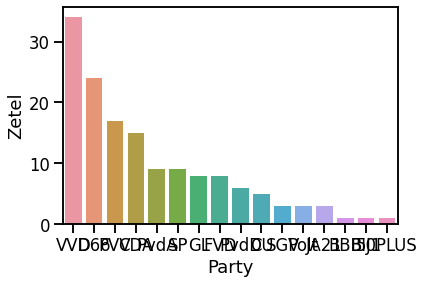

In [ ]:
sns.barplot(data=df_zetels, x='Party', y='Zetel')

In [ ]:
partijen_termen = {'VVD':['VVD', 'Volkspartij voor Vrijheid en Democratie',],
                   'D66':['D66', 'Democraten 66', "D'66"],
                   'PVV':['PVV', 'Partij voor de Vrijheid'],
                   'CDA':['CDA', 'Christen-Democratisch Appèl'],
                   'PvdA':['PvdA','PVDA', 'Partij van de Arbeid'],
                   'SP':['SP', 'Socialistische Partij'],
                   'GL':['GL', 'GroenLinks'],
                   'FVD': ['FVD', 'Forum Voor Democratie'],
                   'PvdD':['PvdD','Partij voor de Dieren'],
                   'CU':['CU', 'Christen Unie'],
                   'SGP':['SGP', 'Staatkundig Gereformeerde Partij'],
                   'Volt':['Volt'],
                   'JA21':['JA21'],
                   'BBB':['BBB', 'Boeren Burger Beweging'],
                   'BIJ1':['BIJ1'],
                   '50PLUS':['50PLUS'],
                   }

print(partijen_termen.keys())                

dict_keys(['VVD', 'D66', 'PVV', 'CDA', 'PvdA', 'SP', 'GL', 'FVD', 'PvdD', 'CU', 'SGP', 'Volt', 'JA21', 'BBB', 'BIJ1', '50PLUS'])


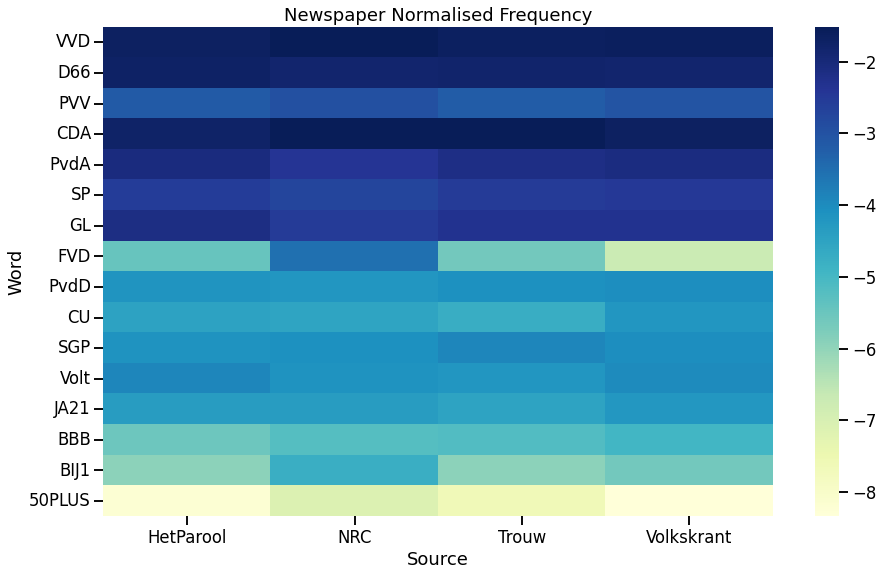

In [ ]:
# Rutte 3: VVD, D66, CDA, CU
visualise_term_mention(df, partijen_termen)

In [ ]:
politici_termen = {'Rutte':['Rutte'],
                   'Kaag':['Kaag'],
                   'Wilders':['Wilders'],
                   'Hoekstra':['Hoekstra'],
                   'Ploumen':['Ploumen'],
                   'Marijnissen':['Marijnissen'],
                   'Klaver':['Klaver'],
                   'Baudet': ['Baudet'],
                   'Ouwehand':['Ouwehand'],
                   'Segers':['Segers'],
                   'Staaij':['Staaij'],
                   'Dassen':['Dassen'],
                   'Eerdmans':['Eerdmans'],
                   'Plas':['Plas'],
                   'Simons':['Simons'],
                   'Den Haan':['Den Haan'],
                   }

print(politici_termen.keys())

dict_keys(['Rutte', 'Kaag', 'Wilders', 'Hoekstra', 'Ploumen', 'Marijnissen', 'Klaver', 'Baudet', 'Ouwehand', 'Segers', 'Staaij', 'Dassen', 'Eerdmans', 'Plas', 'Simons', 'Den Haan'])


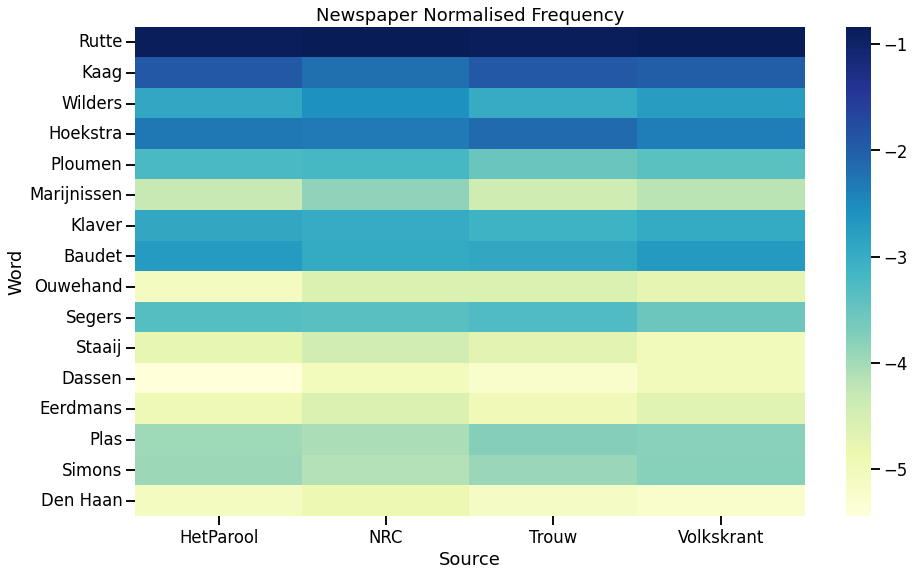

In [ ]:
visualise_term_mention(df, politici_termen)

In [ ]:
def visualise_relative_mention(frame, words, normalisation=True):
  df = frame.copy(deep=True)

  for w in words.keys():
    df[w] = 0
    for term in words[w]:
      df[w] += df.cleantext.str.count(term)

  df_word_counts = pd.DataFrame()

  for w in words:
    df_word_counts[w] = df.groupby("Source")[w].agg("sum")

  df_word_counts = df_word_counts.reset_index()
  df_word_mentions = df_word_counts.melt("Source")

  df_word_mentions = df_word_mentions.rename(columns={'variable':'Word','value':'Frequency'})

  df_ave = pd.DataFrame(df_word_mentions.groupby('Word').mean()).reset_index().rename(columns={'Frequency':'Average'})
  df_word_mentions = df_word_mentions.merge(df_ave, on='Word')
  df_word_mentions['Frequency'] = df_word_mentions['Frequency']/df_word_mentions['Average']
    
  if normalisation:
    df_norm = df_word_mentions.groupby('Source').sum('Frequency').reset_index().rename(columns={'Frequency':'Total Freq'})
    df_word_mentions = df_word_mentions.merge(df_norm, on='Source')
    df_word_mentions['Normalised_Freq'] = df_word_mentions['Frequency']/df_word_mentions['Total Freq']
    
  mentions = df_word_mentions.pivot("Word", "Source", "Normalised_Freq")
  mentions = mentions.reindex(words.keys())

  # bigger plot elements suitable for giving talks
  sns.set_context("talk")
  # set figure size
  plt.figure(figsize=(15,9))
  # Time series plot with Seaborn lineplot()
  sns.heatmap(mentions, cmap='coolwarm')
  # axis labels
  plt.title("Newspaper Relative Normalised Frequency")

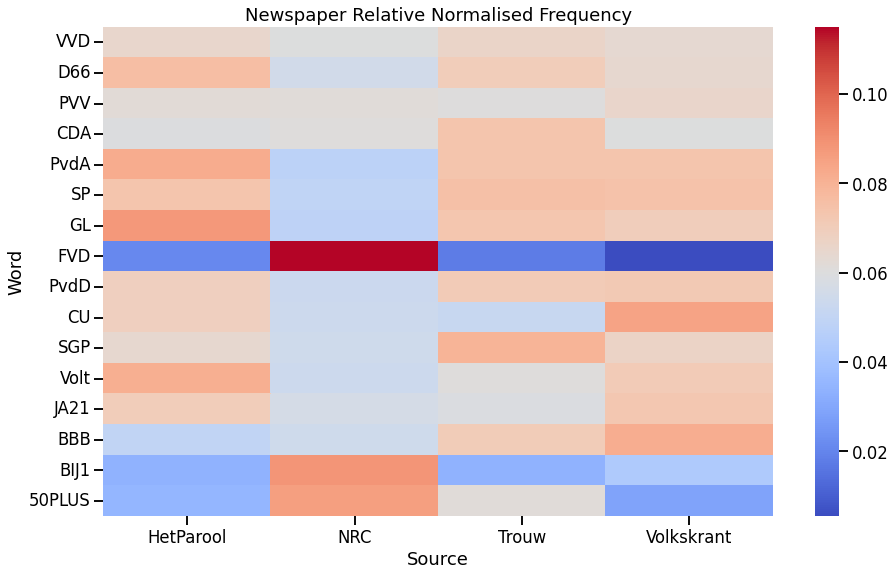

In [ ]:
visualise_relative_mention(df, partijen_termen)

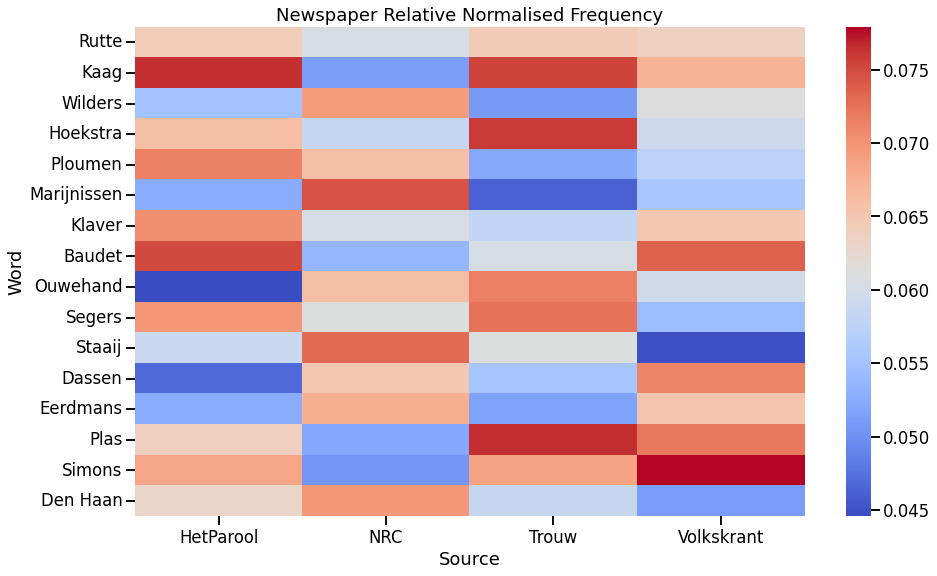

In [ ]:
visualise_relative_mention(df, politici_termen)